In [1]:
import os
import sys
from math import fabs
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pandas import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import requests
import json
import heapq

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import plot_model, to_categorical

import imp
import module as module

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_columns = 50

In [2]:
import tensorflow as tf
assert tf.__version__ == '2.0.0'
assert int(tf.__version__[0]) >= 2

# 1. Data loading, exploration and preparation

In [3]:
# ============
# Data loading
# ============

# Reading and writing parquet files:
# https://arrow.apache.org/docs/python/parquet.html

data_pq = pq.read_table('data.parquet') 
data = data_pq.to_pandas()
data.head()

,uuid,cc3,color1,polka dot,floral,checker
0,004b8_xRpqDn3Gi7deWgA9dCFTSqUb,CASUAL_DRESSES,VARIOUS,0,0,0
1,02089_tvXR6Kt1R735eMgjjLnrWdbY,BLOUSES,GREEN,0,1,0
2,03f0a_uVchHbTLFTvsyaD69ZVP4Lhv,TANK_TOPS,VARIOUS,0,1,0
3,03ce5_HnMQe5Aqimp8KLnyELn5kMvZ,SHIRTS,LIGHT-BLUE,0,0,0
4,04057_39NFDsDVJJJ8FvZa7dHGZsB2,CASUAL_DRESSES,BLACK,0,1,0


In [4]:
test_pq = pq.read_table('test.parquet')
test_pd = test_pq.to_pandas()
test_pd.head()

,uuid
0,01214_HahXniyBFwRjdgv1Z2GtTN4y
1,005ce_nRriUxiS8iyLBW5ipdem5CrA
2,020b8_1um37vo4nagrTUrPaMnvhXbK
3,033cd_7e58vR1T9vW2R7pnSDNUhLoK
4,00f4a_ntveDEhQknB7cohthb4eeHd8


In [5]:
example_predictions_pq = pq.read_table('example_predictions.parquet')
example_predictions = example_predictions_pq.to_pandas()
example_predictions.head()

,uuid,category1,category2,polka dot,floral,checker
0,01214_HahXniyBFwRjdgv1Z2GtTN4y,0,2,1,0,1
1,005ce_nRriUxiS8iyLBW5ipdem5CrA,2,0,1,0,1
2,020b8_1um37vo4nagrTUrPaMnvhXbK,3,1,1,1,1
3,033cd_7e58vR1T9vW2R7pnSDNUhLoK,2,4,1,0,0
4,00f4a_ntveDEhQknB7cohthb4eeHd8,3,2,1,0,1


In [6]:
len(data), len(test_pd), len(example_predictions)

(3547, 429, 429)

In [7]:
# ==========================
# Main parameters of project (ideally this should be read from a configuration file)
# ==========================

pwd = os.getcwd()

# the files are compressed to 0.7 their original size
height, width = 301, 217 
columns_tags=['polka dot', 'floral', 'checker']
#columns_cc3 programmatically defined from cc3 column


In [8]:
# ================================
# ENCODING OF CATEGORICAL FEATURES
# ================================

# a. Label encoding of cc3 and color1

categorical_target = ['cc3','color1']
categorical_target_encoders = []

le_dico = {}
for item in categorical_target:
    le = LabelEncoder()
    le.fit(data[item])
    data[item+'_le'] = le.transform(data[item])
    print(item, le.classes_, le.transform(le.classes_), le.inverse_transform(le.transform(le.classes_)) ) #le.classes_ gives the unique values
    print()
    categorical_target_encoders.append(le)
    le_dico[item] = le

data.head(10) 

cc3 ['BLOUSES' 'CASUAL_DRESSES' 'MINI_DRESSES' 'SHIRTS' 'TANK_TOPS'] [0 1 2 3 4] ['BLOUSES' 'CASUAL_DRESSES' 'MINI_DRESSES' 'SHIRTS' 'TANK_TOPS']

color1 ['BLACK' 'BLUE' 'BODY' 'BROWN' 'BURGUNDY' 'CORAL' 'CREAM' 'DARK-GREEN'
 'GOLD' 'GREEN' 'GREY' 'KHAKI' 'LIGHT-BLUE' 'LILAC' 'MINT' 'MUSTARD'
 'NAVY' 'ORANGE' 'PINK' 'PURPLE' 'RED' 'ROSE' 'SILVER' 'TURQUOISE'
 'VARIOUS' 'WHITE' 'YELLOW'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] ['BLACK' 'BLUE' 'BODY' 'BROWN' 'BURGUNDY' 'CORAL' 'CREAM' 'DARK-GREEN'
 'GOLD' 'GREEN' 'GREY' 'KHAKI' 'LIGHT-BLUE' 'LILAC' 'MINT' 'MUSTARD'
 'NAVY' 'ORANGE' 'PINK' 'PURPLE' 'RED' 'ROSE' 'SILVER' 'TURQUOISE'
 'VARIOUS' 'WHITE' 'YELLOW']



,uuid,cc3,color1,polka dot,floral,checker,cc3_le,color1_le
0,004b8_xRpqDn3Gi7deWgA9dCFTSqUb,CASUAL_DRESSES,VARIOUS,0,0,0,1,24
1,02089_tvXR6Kt1R735eMgjjLnrWdbY,BLOUSES,GREEN,0,1,0,0,9
2,03f0a_uVchHbTLFTvsyaD69ZVP4Lhv,TANK_TOPS,VARIOUS,0,1,0,4,24
3,03ce5_HnMQe5Aqimp8KLnyELn5kMvZ,SHIRTS,LIGHT-BLUE,0,0,0,3,12
4,04057_39NFDsDVJJJ8FvZa7dHGZsB2,CASUAL_DRESSES,BLACK,0,1,0,1,0
5,016d6_YQLmwZ6Bd5j111jrpwuS32Lf,TANK_TOPS,BLUE,1,0,0,4,1
6,00ee8_3hboMf2ssLCcEeRVBojqP1c2,CASUAL_DRESSES,BLUE,0,0,0,1,1
7,00820_X6Y7Dgvomz4LpApPS7mVGxEC,BLOUSES,WHITE,1,0,0,0,25
8,03548_tPCALYeSoddrydoVwfiWiyfk,BLOUSES,BLACK,1,0,0,0,0
9,024c7_K2J16Ry4tKLubWhNzoduZU9v,TANK_TOPS,VARIOUS,0,1,0,4,24


In [9]:
#b. Categorical encoding of cc3

dd = to_categorical(data['cc3_le'],num_classes=5).astype(int)
le = le_dico['cc3']
columns_cc3 = le.inverse_transform([0,1,2,3,4]).tolist()
columns_cc3 = [x.lower() for x in columns_cc3]
dd_pd = pd.DataFrame(dd,columns=columns_cc3)

data = pd.concat([data,dd_pd], axis=1) 
data.head(10)

,uuid,cc3,color1,polka dot,floral,checker,cc3_le,color1_le,blouses,casual_dresses,mini_dresses,shirts,tank_tops
0,004b8_xRpqDn3Gi7deWgA9dCFTSqUb,CASUAL_DRESSES,VARIOUS,0,0,0,1,24,0,1,0,0,0
1,02089_tvXR6Kt1R735eMgjjLnrWdbY,BLOUSES,GREEN,0,1,0,0,9,1,0,0,0,0
2,03f0a_uVchHbTLFTvsyaD69ZVP4Lhv,TANK_TOPS,VARIOUS,0,1,0,4,24,0,0,0,0,1
3,03ce5_HnMQe5Aqimp8KLnyELn5kMvZ,SHIRTS,LIGHT-BLUE,0,0,0,3,12,0,0,0,1,0
4,04057_39NFDsDVJJJ8FvZa7dHGZsB2,CASUAL_DRESSES,BLACK,0,1,0,1,0,0,1,0,0,0
5,016d6_YQLmwZ6Bd5j111jrpwuS32Lf,TANK_TOPS,BLUE,1,0,0,4,1,0,0,0,0,1
6,00ee8_3hboMf2ssLCcEeRVBojqP1c2,CASUAL_DRESSES,BLUE,0,0,0,1,1,0,1,0,0,0
7,00820_X6Y7Dgvomz4LpApPS7mVGxEC,BLOUSES,WHITE,1,0,0,0,25,1,0,0,0,0
8,03548_tPCALYeSoddrydoVwfiWiyfk,BLOUSES,BLACK,1,0,0,0,0,1,0,0,0,0
9,024c7_K2J16Ry4tKLubWhNzoduZU9v,TANK_TOPS,VARIOUS,0,1,0,4,24,0,0,0,0,1


[]

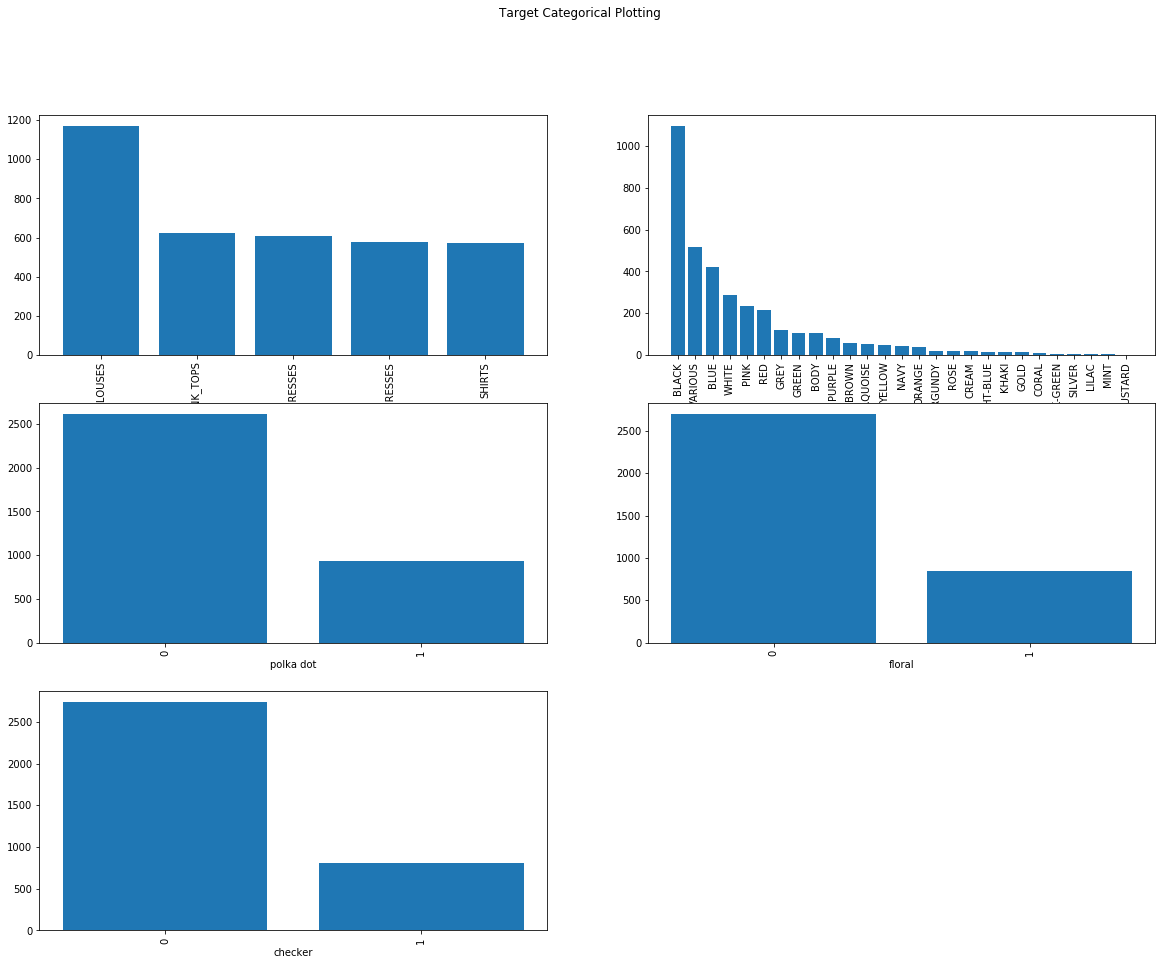

In [10]:
# ===============================
# Basic exploratory data analysis
# ===============================

# Let's plot the distributions of 
# - the different classes of cc3
# - the different colors
# - the 3 different tag labels

fig, axs = plt.subplots(1, 2, figsize=(20, 15), sharey=False)
fig.suptitle('Target Categorical Plotting')

for i,column in enumerate(['cc3', 'color1', 'polka dot', 'floral', 'checker']):
    ax1 = plt.subplot(3,2,i+1)
    items = data[column].value_counts().index.tolist()
    values = data[column].value_counts().values.tolist()
    ax1.bar(items, values)
    y_pos = range(len(items))
    plt.xticks(y_pos, items, rotation=90)
    ax1.set_xlabel(column)

plt.plot()

[]

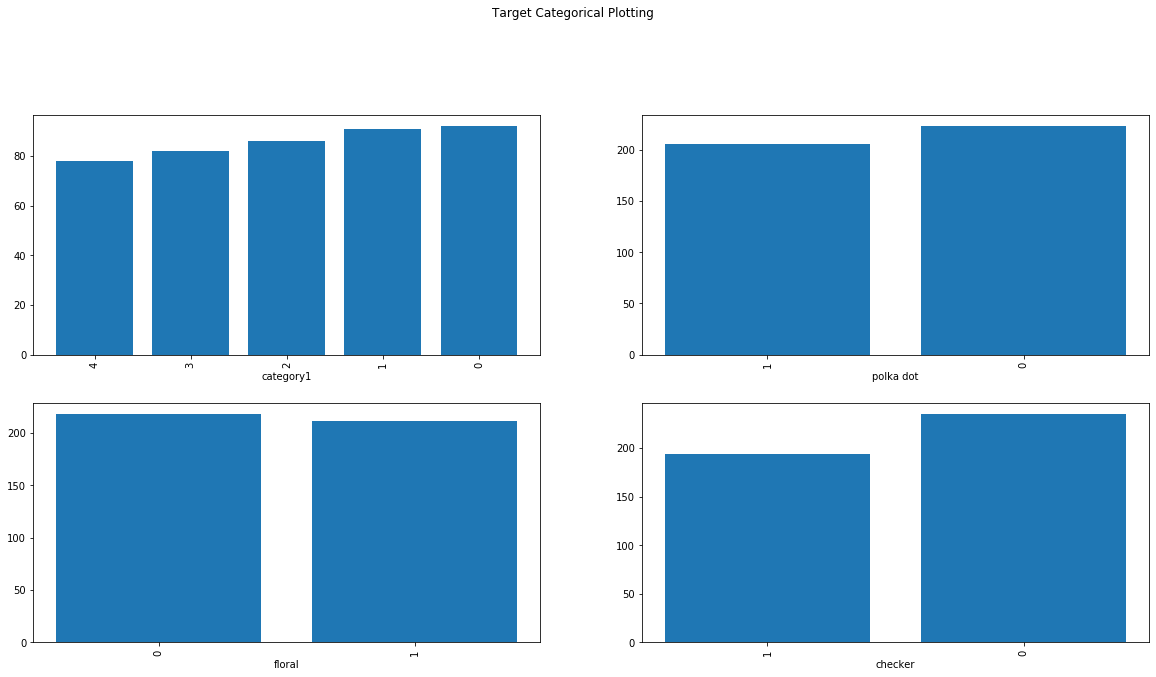

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15), sharey=False)
fig.suptitle('Target Categorical Plotting')

for i,column in enumerate(['category1', 'polka dot', 'floral', 'checker']):
    ax1 = plt.subplot(3,2,i+1)
    items = example_predictions[column].value_counts().index.tolist()
    values = example_predictions[column].value_counts().values.tolist()
    ax1.bar(items, values)
    y_pos = range(len(items))
    plt.xticks(y_pos, items, rotation=90)
    ax1.set_xlabel(column)

plt.plot()

<Figure size 432x288 with 0 Axes>

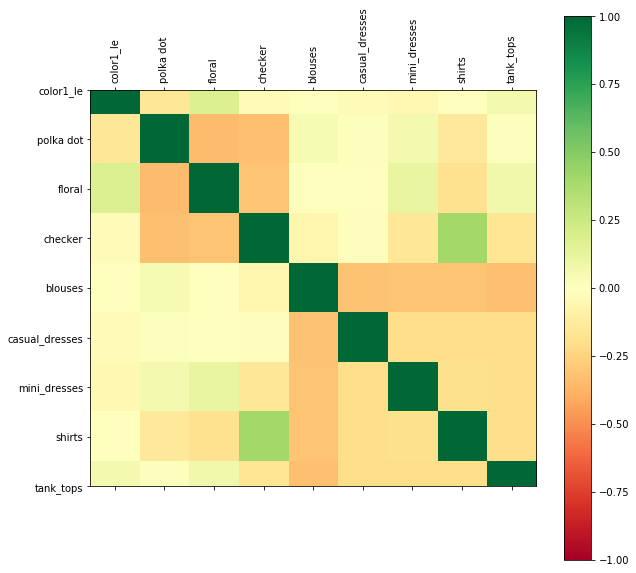

,field vs field,correlation
9,checker vs shirts,0.40
3,floral vs polka dot,-0.34
6,checker vs polka dot,-0.33
11,blouses vs casual_dresses,-0.32
14,blouses vs tank_tops,-0.32
7,checker vs floral,-0.31
12,blouses vs mini_dresses,-0.31
13,blouses vs shirts,-0.31
17,casual_dresses vs tank_tops,-0.21
20,shirts vs tank_tops,-0.20


In [12]:
# =========================================
# Inspection of correlations between labels
# =========================================

# The idea is to see if there exist significant correlations between cc3 classes and tags labels. 
# For example, the "checker vs shirts" shows that there might be a benefit to use a multi-task model over 2 disjoined models (one for cc3, one for tags). 
# The multi-task model would take advantage of such correlation. 

imp.reload(module)

feature_cols= ['color1_le', 'polka dot', 'floral', 'checker'] + columns_cc3

corr,df_corr_sorted = module.Get_and_Plot_correlations(data[feature_cols], size=10, min_cor=0.1)
df_corr_sorted[['field vs field','correlation']]

In [13]:
# ====================================================================
# Balancing the dataset to have similar number of samples in cc3 class
# ====================================================================

imp.reload(module)

data_balanced = module.downsample(data, 'cc3', random_state=42)

print('Size of balanced dataframe: ', len(data_balanced))
print()
print(data_balanced['cc3'].value_counts())
data_balanced.head()   

Size of balanced dataframe:  2855

TANK_TOPS         571
MINI_DRESSES      571
SHIRTS            571
BLOUSES           571
CASUAL_DRESSES    571
Name: cc3, dtype: int64


,uuid,cc3,color1,polka dot,floral,checker,cc3_le,color1_le,blouses,casual_dresses,mini_dresses,shirts,tank_tops
0,02484_m8tnrmVszomivCaHZdH4K5pd,MINI_DRESSES,BLUE,0,0,0,2,1,0,0,1,0,0
1,04a95_S83HqSh7EWHzJ3AT8zze2HJ6,SHIRTS,BLACK,1,0,0,3,0,0,0,0,1,0
2,00999_bz4gVZYvn9TKHRX38rhm25Q1,CASUAL_DRESSES,BLUE,1,0,0,1,1,0,1,0,0,0
3,0375a_BFJuf9e59e42oo5gS3yF4xuW,SHIRTS,BLACK,0,0,1,3,0,0,0,0,1,0
4,007b1_6VGvfKiV4PRppcSpKUK6fDSa,BLOUSES,GOLD,1,0,0,0,8,1,0,0,0,0


In [14]:
# ==============================================
# Adding file format to file names in dataframes
# ==============================================

def append_ext(fn):
    return fn+".jpeg"

data_balanced["uuid"] = data_balanced["uuid"].apply(append_ext)

test_pd["uuid"] = test_pd["uuid"].apply(append_ext)

example_predictions["uuid"] = example_predictions["uuid"].apply(append_ext)

data_balanced.head()

,uuid,cc3,color1,polka dot,floral,checker,cc3_le,color1_le,blouses,casual_dresses,mini_dresses,shirts,tank_tops
0,02484_m8tnrmVszomivCaHZdH4K5pd.jpeg,MINI_DRESSES,BLUE,0,0,0,2,1,0,0,1,0,0
1,04a95_S83HqSh7EWHzJ3AT8zze2HJ6.jpeg,SHIRTS,BLACK,1,0,0,3,0,0,0,0,1,0
2,00999_bz4gVZYvn9TKHRX38rhm25Q1.jpeg,CASUAL_DRESSES,BLUE,1,0,0,1,1,0,1,0,0,0
3,0375a_BFJuf9e59e42oo5gS3yF4xuW.jpeg,SHIRTS,BLACK,0,0,1,3,0,0,0,0,1,0
4,007b1_6VGvfKiV4PRppcSpKUK6fDSa.jpeg,BLOUSES,GOLD,1,0,0,0,8,1,0,0,0,0


# 2. Multi-task Modelling

The model is a 2-task model:

* The task 1 is a multi-class classification of the cc3 classes. The output for this task (see function transfer_learning_model) is a dense(5) layer, to be matched with a one-hot-encoded version of the cc3 columns (containing 5 classes). As it is a multi-class problem, the loss function for that task is a softmax, i.e., the probabilities of all classes sum to 1.

* The task 2 is a multi-label classification of the polka dot, floral, checker columns. The output for this task (see function transfer_learning_model) is a dense(3) layer, to be matched with these 3 columns (already in one-hot-encoded format). As it is a multi-label problem, the loss function for that task is a sigmoid, i.e., the probabilities for each label is independent from the other labels.      

It is a transfer-learning model. It is composed of a convolutional base (VGG16 net), and a dense output for each task. 

It is using the tf.keras api, as it has become the standard go-to from TF 2.0

In [15]:
# ================================
# Model definition and preparation
# ================================

# Task 1: classification of one class of clothes among 5; a typical multi-class task
# Task 2: detection of 3 potential tags; a typical multi-label task

# Great resources:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# multi-class vs multi-output: simple description: https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
#fashion_mnist: https://www.tensorflow.org/tutorials/keras/classification

imp.reload(module)

tf.keras.backend.clear_session()  # For easy reset of notebook state.
tf.keras.backend.set_floatx('float32')

columns = columns_cc3 + columns_tags

# Training data will be augmented
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest')

# Note that the validation and test data should not be augmented!
test_datagen=ImageDataGenerator(rescale=1./255.)

#don't forget to shuffle the df rows for train and validation, to be sure we don't include any weird trend
train_generator=datagen.flow_from_dataframe(
    dataframe=data_balanced[:2300],
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=columns,
    batch_size=50,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(height,width))

valid_generator=test_datagen.flow_from_dataframe(  # Here: not using augmentation in validation set
    dataframe=data_balanced[2300:2600],
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=columns,
    batch_size=25,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(height,width))

heldout_generator=test_datagen.flow_from_dataframe(
    dataframe=data_balanced[2600:],
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=None, 
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None, 
    target_size=(height,width))

inference_generator=test_datagen.flow_from_dataframe(
    dataframe=test_pd,
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=None,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(height,width))

model = module.transfer_learning_model(height,width)

model.compile(optimizer='adam',
              loss = {'cc3':"categorical_crossentropy",
                      'tags':"binary_crossentropy"}, 
              loss_weights = {'cc3': 1.,'tags': 1.}, 
              metrics = ["accuracy"])

callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min'),
             ModelCheckpoint(filepath='./model_training/tf_keras_model/model-epoch{epoch:02d}-cc3_loss{cc3_loss:.4f}-tags_loss{tags_loss:.4f}-val_cc3_acc{val_cc3_accuracy:.2f}-val_tags_acc{val_tags_accuracy:.2f}.h5',
                             monitor='val_loss',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             verbose=1),
             CSVLogger('training_{0}.log'.format('vgg16'),
                       separator=',',
                       append=True),
                       #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
                       TerminateOnNaN()
            ]

def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,0:5],batch_y[:,5:8]])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_HELDOUT=heldout_generator.n//heldout_generator.batch_size
STEP_SIZE_INFERENCE=inference_generator.n//inference_generator.batch_size

Found 2300 validated image filenames.
Found 300 validated image filenames.
Found 255 validated image filenames.
Found 429 validated image filenames.


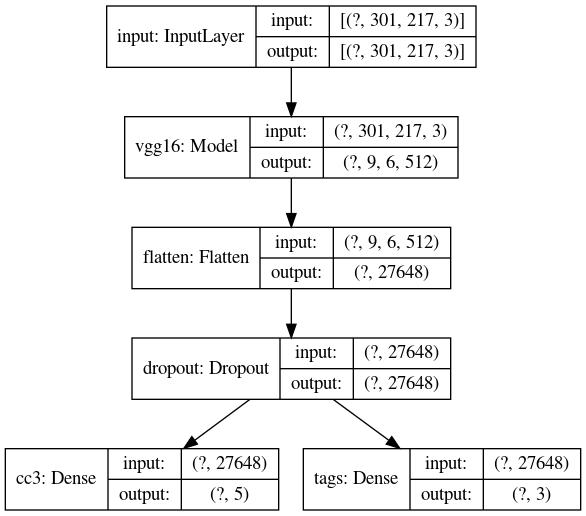

In [16]:
# ===============
# Model structure
# ===============

plot_model(model, to_file='./model_training/tf_keras_model/model.png', show_shapes=True)
plot_model(model, show_shapes=True)

In [17]:
with open('./model_training/tf_keras_model/model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
model.summary()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 301, 217, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 9, 6, 512)    14714688    input[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 27648)        0           vgg16[1][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 27648)        0           flatten[0][0]                    
______________________________________________________________________________________________

In [18]:
# =============
# MAIN TRAINING ("Feature extraction")
# =============

# following https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
history = model.fit_generator(generator=generator_wrapper(train_generator),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(valid_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=callbacks,
)

Epoch 1/15
45/46 [============================>.] - ETA: 1s - loss: 2.3572 - cc3_loss: 1.9176 - tags_loss: 0.4396 - cc3_accuracy: 0.3351 - tags_accuracy: 0.8073
Epoch 00001: saving model to ./model_training/tf_keras_model/model-epoch01-cc3_loss1.9113-tags_loss0.4367-val_cc3_acc0.41-val_tags_acc0.84.h5
46/46 [==============================] - 95s 2s/step - loss: 2.3480 - cc3_loss: 1.9113 - tags_loss: 0.4367 - cc3_accuracy: 0.3361 - tags_accuracy: 0.8090 - val_loss: 1.7757 - val_cc3_loss: 1.3794 - val_tags_loss: 0.3963 - val_cc3_accuracy: 0.4133 - val_tags_accuracy: 0.8400
Epoch 2/15
45/46 [============================>.] - ETA: 1s - loss: 1.7845 - cc3_loss: 1.4471 - tags_loss: 0.3374 - cc3_accuracy: 0.4253 - tags_accuracy: 0.8582
Epoch 00002: saving model to ./model_training/tf_keras_model/model-epoch02-cc3_loss1.4547-tags_loss0.3359-val_cc3_acc0.50-val_tags_acc0.84.h5
46/46 [==============================] - 84s 2s/step - loss: 1.7906 - cc3_loss: 1.4547 - tags_loss: 0.3359 - cc3_accura

45/46 [============================>.] - ETA: 1s - loss: 1.4985 - cc3_loss: 1.2288 - tags_loss: 0.2697 - cc3_accuracy: 0.5427 - tags_accuracy: 0.8844
Epoch 00015: saving model to ./model_training/tf_keras_model/model-epoch15-cc3_loss1.2345-tags_loss0.2693-val_cc3_acc0.44-val_tags_acc0.86.h5
46/46 [==============================] - 84s 2s/step - loss: 1.5038 - cc3_loss: 1.2345 - tags_loss: 0.2693 - cc3_accuracy: 0.5413 - tags_accuracy: 0.8846 - val_loss: 2.3418 - val_cc3_loss: 1.9628 - val_tags_loss: 0.3790 - val_cc3_accuracy: 0.4367 - val_tags_accuracy: 0.8633


[]

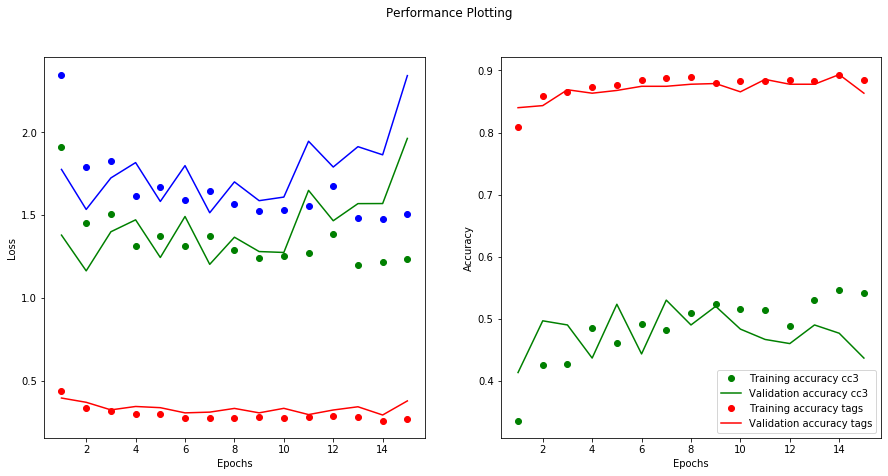

In [19]:
# ========================
# Plot of training history
# ========================

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_cc3 = history.history['cc3_loss']
val_loss_cc3 = history.history['val_cc3_loss']

loss_tags = history.history['tags_loss']
val_loss_tags = history.history['val_tags_loss']

acc_cc3 = history.history['cc3_accuracy']
val_acc_cc3 = history.history['val_cc3_accuracy']

acc_tags = history.history['tags_accuracy']
val_acc_tags = history.history['val_tags_accuracy']

epochs_axis = range(1, len(loss)+1)

fig = plt.figure(1,figsize=(15, 7))
fig.suptitle('Performance Plotting')

ax1 = plt.subplot(1,2,1)
ax1.plot(epochs_axis, loss, 'bo', label='Training loss')
ax1.plot(epochs_axis, val_loss, 'b', label='Validation loss')
ax1.plot(epochs_axis, loss_cc3, 'go', label='Training loss cc3')
ax1.plot(epochs_axis, val_loss_cc3, 'g', label='Validation loss cc3')
ax1.plot(epochs_axis, loss_tags, 'ro', label='Training loss tags')
ax1.plot(epochs_axis, val_loss_tags, 'r', label='Validation loss tags')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax1 = plt.subplot(1,2,2)
ax1.plot(epochs_axis, acc_cc3, 'go', label='Training accuracy cc3')
ax1.plot(epochs_axis, val_acc_cc3, 'g', label='Validation accuracy cc3')
ax1.plot(epochs_axis, acc_tags, 'ro', label='Training accuracy tags')
ax1.plot(epochs_axis, val_acc_tags, 'r', label='Validation accuracy tags')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

plt.legend()
plt.savefig('./model_training/tf_keras_model/Loss_Accuracy_plots.png')
plt.plot()

In [28]:
# =======================
# PERFORMANCE MEASUREMENT
# =======================

# Model reloading (if needed)
#model = load_model('./model_training/run1_30epochs/model-28-1.3549-0.4017-0.41-0.82.h5')
#model = load_model('./model_training/run2_70epochs/model-38-1.3622-0.3855-0.57-0.85.h5')
#model = load_model('./model_training/run_224x224/model-06-1.2721-0.2832-0.55-0.88.h5')
#model = load_model('./model_training/run_224x224_validationsplit/model-epoch12-cc3_loss1.1933-tags_loss0.2694-val_cc3_acc0.49-val_tags_acc0.88.h5')
#model = load_model('./model_training/run_224x224_validationsplit_dense64/model-epoch19-cc3_loss1.2172-tags_loss0.3653-val_cc3_acc0.50-val_tags_acc0.86.h5')
#model = load_model('./model_training/run2_224x224/model-epoch10-cc3_loss1.2352-tags_loss0.2705-val_cc3_acc0.57-val_tags_acc0.88.h5')
#model = load_model('./model_training/run_224x224_dense64/model-epoch26-cc3_loss1.2449-tags_loss0.3764-val_cc3_acc0.47-val_tags_acc0.86.h5')
#model = load_model('./model_training/run_224x224_dense64/model-epoch43-cc3_loss1.2083-tags_loss0.3697-val_cc3_acc0.50-val_tags_acc0.86.h5')

model = load_model('./model_training/tf_keras_model/model-epoch09-cc3_loss1.2428-tags_loss0.2830-val_cc3_acc0.52-val_tags_acc0.88.h5')

In [29]:
# ==========================
# Serving on heldout dataset
# ==========================

heldout_generator.reset()
pred=model.predict_generator(heldout_generator,
                             steps=STEP_SIZE_HELDOUT,
                             verbose=1)

255/255 [==============================] - 5s 20ms/step


In [30]:
# ===================
# Performance for cc3
# ===================

y_pred_cc3 = pred[0]
y_pred_tags = pred[1]

y_true = data_balanced[2600:]['cc3_le'].values

# Useful resources: top 1, top 2, top k accuracy.
# # meaning of top-1, top-5: https://stackoverflow.com/questions/37668902/evaluation-calculate-top-n-accuracy-top-1-and-top-5
# https://stackoverflow.com/questions/44799516/tensorflow-is-there-a-metric-to-calculate-and-update-top-k-accuracy 
# https://www.tensorflow.org/api_docs/python/tf/math/in_top_k?version=stable

top1 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=1)).numpy()
top2 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=2)).numpy()
top5 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=5)).numpy()

print('top1, top2, top5 accuracies on the test set: ', top1, top2, top5)

top1, top2, top5 accuracies on the test set:  0.59607846 0.7921569 1.0


In [31]:
# ====================
# Performance for tags
# ====================

y_pred_tags_bool = (y_pred_tags > 0.5)
predictions_tags = y_pred_tags_bool.astype(int)

#columns should be the same order of y_col
results_heldout=pd.DataFrame(predictions_tags, columns=columns_tags)
results_heldout['category1'] = np.argsort(y_pred_cc3)[:,-1]
results_heldout['category2'] = np.argsort(y_pred_cc3)[:,-2]
results_heldout['uuid'] = heldout_generator.filenames
ordered_cols=['uuid', 'category1', 'category2']+columns_tags
results_heldout = results_heldout[ordered_cols] #To get the same column order

for column in columns_tags:    
    y_val = data_balanced[2600:][column].values
    y_val_pred = results_heldout[column].values
    print('Tag: ', item)
    print(classification_report(y_val, y_val_pred))

Tag:  color1
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       198
           1       0.73      0.77      0.75        57

    accuracy                           0.89       255
   macro avg       0.83      0.85      0.84       255
weighted avg       0.89      0.89      0.89       255

Tag:  color1
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       193
           1       0.88      0.79      0.83        62

    accuracy                           0.92       255
   macro avg       0.90      0.88      0.89       255
weighted avg       0.92      0.92      0.92       255

Tag:  color1
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       181
           1       0.87      0.54      0.67        74

    accuracy                           0.84       255
   macro avg       0.85      0.75      0.78       255
weighted avg       0.85      0.84  

In [32]:
# ============================
# Serving on inference dataset
# ============================

inference_generator.reset()
pred=model.predict_generator(inference_generator,
                             steps=STEP_SIZE_INFERENCE,
                             verbose=1)

429/429 [==============================] - 9s 20ms/step


In [33]:
y_pred_cc3 = pred[0]
y_pred_tags = pred[1]

y_pred_tags_bool = (y_pred_tags > 0.5)
predictions_tags = y_pred_tags_bool.astype(int)

#columns should be the same order of y_col
results_inference=pd.DataFrame(predictions_tags, columns=columns_tags)
results_inference['category1'] = np.argsort(y_pred_cc3)[:,-1]
results_inference['category2'] = np.argsort(y_pred_cc3)[:,-2]
results_inference['uuid'] = inference_generator.filenames
ordered_cols=['uuid', 'category1', 'category2']+columns_tags
results_inference = results_inference[ordered_cols] #To get the same column order

le = le_dico['cc3']

results_inference['category1_name'] = le.inverse_transform(results_inference['category1'].values)
results_inference['category2_name'] = le.inverse_transform(results_inference['category2'].values)
results_inference.head()

,uuid,category1,category2,polka dot,floral,checker,category1_name,category2_name
0,01214_HahXniyBFwRjdgv1Z2GtTN4y.jpeg,0,4,0,0,0,BLOUSES,TANK_TOPS
1,005ce_nRriUxiS8iyLBW5ipdem5CrA.jpeg,1,2,0,0,0,CASUAL_DRESSES,MINI_DRESSES
2,020b8_1um37vo4nagrTUrPaMnvhXbK.jpeg,4,1,0,0,1,TANK_TOPS,CASUAL_DRESSES
3,033cd_7e58vR1T9vW2R7pnSDNUhLoK.jpeg,2,1,0,1,0,MINI_DRESSES,CASUAL_DRESSES
4,00f4a_ntveDEhQknB7cohthb4eeHd8.jpeg,4,2,1,0,0,TANK_TOPS,MINI_DRESSES


In [37]:
table = pa.Table.from_pandas(results_inference)
pq.write_table(table, 'predictions.parquet')

# 3. Serving the model using TF-SERVING

In [38]:
# Relevant documentation: 
#https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27
#https://hackernoon.com/how-we-improved-tensorflow-serving-performance-by-over-70-f21b5dad2d98
#https://towardsdatascience.com/deploying-kaggle-solution-with-tensorflow-serving-part-1-of-2-803391c9648
# interesting: https://medium.com/data-science-engineering/productising-tensorflow-keras-models-via-tensorflow-serving-69e191cb1f37

In [39]:
# ==============================================
# Saving the tf.keras model as a .pb saved_model
# ==============================================

# https://www.tensorflow.org/tutorials/keras/save_and_load
# https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27

# First load the saved tf.keras model (so that no need to run part 1 before)

# Model reloading (if needed)
#model = load_model('./model3/run1_30epochs/model-28-1.3549-0.4017-0.41-0.82.h5')
#model = load_model('./model_training/run2_70epochs_224x224/model-06-1.2721-0.2832-0.55-0.88.h5')
#model = load_model('./model_training/run_224x224_validationsplit/model-epoch12-cc3_loss1.1933-tags_loss0.2694-val_cc3_acc0.49-val_tags_acc0.88.h5')
model = load_model('./model_training/tf_keras_model/model-epoch09-cc3_loss1.2428-tags_loss0.2830-val_cc3_acc0.52-val_tags_acc0.88.h5')

# Saving the model to a pb (protobuffer) file for TF-SERVING
model.save('model_training/saved_model/my_model/1/') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_training/saved_model/my_model/1/assets


In [40]:
# Inspection of the tree
!tree $(pwd)/model_training/saved_model

/home/philippe/Documents/github/Vinted_exercise/model_training/saved_model
└── my_model
    └── 1
        ├── assets
        ├── saved_model.pb
        └── variables
            ├── variables.data-00000-of-00002
            ├── variables.data-00001-of-00002
            └── variables.index

4 directories, 4 files


In [41]:
# Inspection of the saved model. Very handy way to check that the dimensions and names of the outputs are ok
!saved_model_cli show --dir $(pwd)/model_training/saved_model/my_model/1/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 301, 217, 3)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['cc3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
    outputs['tags'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:1
  Method name is: tensorflow/serving/predict


In [ ]:
# Useful resources for TF serving:
# https://www.tensorflow.org/guide/saved_model 
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Notes: How to install tf serving (ubuntu)
# https://www.tensorflow.org/tfx/serving/setup
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
# sudo apt-get update
# sudo apt-get install tensorflow-model-server

In [72]:
# ==============================================
# Hosting a model server with TensorFlow Serving
# ==============================================

# Please launch the following command in a terminal, in the same folder of this notebook! This will launch the server hosting the model, and listening to requests:

# tensorflow_model_server --model_base_path=$(pwd)/model_training/saved_model/my_model/ --rest_api_port=9000 --model_name=my_model

Raw prediction:  {'tags': [0.000240486203, 0.000463559263, 0.949686587], 'cc3': [0.0624303557, 0.00506983604, 0.0181317851, 0.913478673, 0.000889341405]}
cc3: ['shirts', 'blouses']
tags: ['checker']


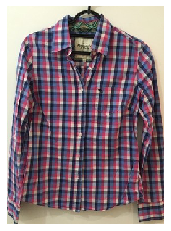

In [42]:
# ======================================
# Example of serving on a single picture
# ======================================

file = './data/00a5f_ozkvtHQfYePXmFMPyBjWao97.jpeg'
#file = './data/02acd_vP63wx1pq9avpoLptz47kd7r.jpeg'
#file = './data/0436c_3UNwTkvQBb5qS8A7ENmuVkiJ.jpeg'
img = tf.keras.preprocessing.image.load_img(file, target_size=[height,width])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img) / 255. 
x = x[tf.newaxis,...]

data = json.dumps({"signature_name": "serving_default","instances": x.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:9000/v1/models/my_model:predict',
                              data=data, headers=headers)
predictions = np.array(json.loads(json_response.text)["predictions"])[0]
print('Raw prediction: ', predictions)

# Getting 2 highest probability indices for cc3
ind_cc3 = heapq.nlargest(2, range(len(predictions['cc3'])), predictions['cc3'].__getitem__) 
print('cc3:', [columns_cc3[item] for item in ind_cc3])

# Getting indices of tags for which probability > 0.5
ind_tags = [i for i, x in enumerate(predictions['tags']) if x>=0.5]
print('tags:', [columns_tags[item] for item in ind_tags])

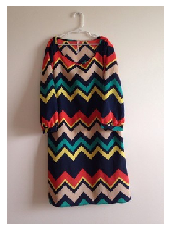

File:  ./data/01214_HahXniyBFwRjdgv1Z2GtTN4y.jpeg
Raw prediction:  {'tags': [7.24294296e-05, 0.00296179508, 0.00120909209], 'cc3': [0.629934847, 0.107440852, 0.0797702447, 0.0238986928, 0.158955306]}
cc3: ['blouses', 'tank_tops']
tags: []




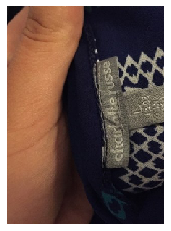

File:  ./data/005ce_nRriUxiS8iyLBW5ipdem5CrA.jpeg
Raw prediction:  {'cc3': [0.00772170816, 0.432352513, 0.406983, 0.00171094073, 0.15123193], 'tags': [0.19595553, 0.240282744, 0.0063211]}
cc3: ['casual_dresses', 'mini_dresses']
tags: []




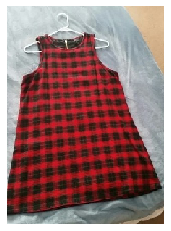

File:  ./data/020b8_1um37vo4nagrTUrPaMnvhXbK.jpeg
Raw prediction:  {'tags': [0.00335023855, 0.000670621463, 0.90820992], 'cc3': [0.0335068926, 0.350117296, 0.16587618, 0.0106522413, 0.43984732]}
cc3: ['tank_tops', 'casual_dresses']
tags: ['checker']




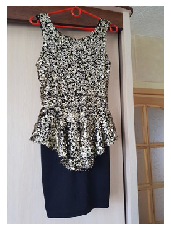

File:  ./data/033cd_7e58vR1T9vW2R7pnSDNUhLoK.jpeg
Raw prediction:  {'tags': [0.0415214971, 0.953321755, 2.8100867e-05], 'cc3': [0.00190959813, 0.332505345, 0.645121, 0.000623092754, 0.0198409762]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['floral']




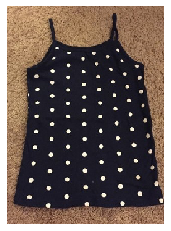

File:  ./data/00f4a_ntveDEhQknB7cohthb4eeHd8.jpeg
Raw prediction:  {'cc3': [0.00805465505, 0.0329170674, 0.0351617187, 0.00149722234, 0.922369361], 'tags': [0.973720074, 0.00156489608, 0.0093655875]}
cc3: ['tank_tops', 'mini_dresses']
tags: ['polka dot']




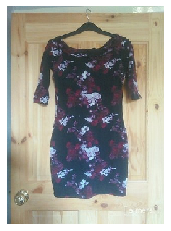

File:  ./data/01e0f_GY1KqT78HX9QUfr5F57jS5X9.jpeg
Raw prediction:  {'tags': [0.00586923, 0.988503873, 0.0320345052], 'cc3': [0.0889088288, 0.172435328, 0.148972929, 0.571197152, 0.0184857603]}
cc3: ['shirts', 'casual_dresses']
tags: ['floral']




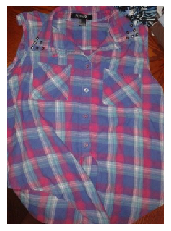

File:  ./data/01284_xCbmAarz3uGwiVtQ5mH2yK8A.jpeg
Raw prediction:  {'cc3': [0.0729881674, 0.010417942, 0.00704663573, 0.825773358, 0.0837738514], 'tags': [0.00362927117, 0.00166875601, 0.358285666]}
cc3: ['shirts', 'tank_tops']
tags: []




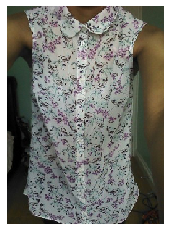

File:  ./data/02272_GN1wPQpKYsFFZsDFtwWPCv1U.jpeg
Raw prediction:  {'tags': [0.29006651, 0.936695158, 1.25851311e-05], 'cc3': [0.357396543, 0.00920560863, 0.0247556381, 0.00953336153, 0.599108934]}
cc3: ['tank_tops', 'blouses']
tags: ['floral']




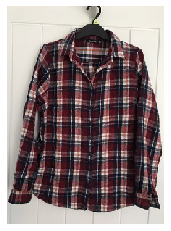

File:  ./data/03729_kfj8vTFTD9rLDd41ZCMAg9ui.jpeg
Raw prediction:  {'cc3': [0.0304299742, 0.014406682, 0.0047191605, 0.949915707, 0.00052848208], 'tags': [0.000470263971, 0.000241343674, 0.923115611]}
cc3: ['shirts', 'blouses']
tags: ['checker']




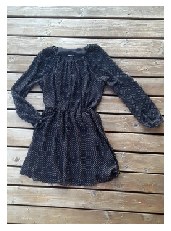

File:  ./data/04240_xtwFEMnzhynRpojGWjfEus4f.jpeg
Raw prediction:  {'tags': [0.781524658, 0.0122214397, 0.155216366], 'cc3': [0.024551319, 0.379576117, 0.440069795, 0.12799713, 0.0278056134]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




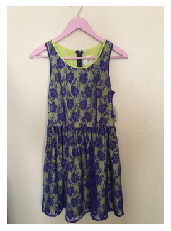

File:  ./data/01ec5_YNqEBKnyoLsKz2SVnW8tLHYy.jpeg
Raw prediction:  {'tags': [0.0230034627, 0.772871494, 0.0183077492], 'cc3': [0.00430468563, 0.351217628, 0.401082665, 4.3353517e-05, 0.243351609]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['floral']




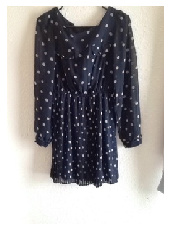

File:  ./data/018cd_F9Dg84vAB1XvtwRtnUxfJ4Ya.jpeg
Raw prediction:  {'tags': [0.500251055, 0.930937171, 0.00276655774], 'cc3': [0.271885306, 0.403503269, 0.212078288, 0.107810572, 0.00472250348]}
cc3: ['casual_dresses', 'blouses']
tags: ['polka dot', 'floral']




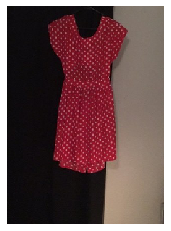

File:  ./data/00039_wGiQHhRXTpJeLgWhVcHNUCAz.jpeg
Raw prediction:  {'cc3': [0.00495173363, 0.180778205, 0.788433671, 0.0157019421, 0.0101344343], 'tags': [0.958378673, 0.0690532848, 0.0146996547]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




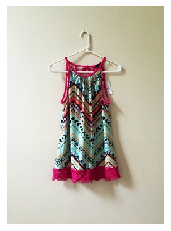

File:  ./data/01fc3_i6xADk4iDhBNgKMUsbGnAJNp.jpeg
Raw prediction:  {'cc3': [0.00474317232, 0.355570197, 0.215823248, 2.5222369e-05, 0.423838228], 'tags': [0.0181736257, 0.794808567, 0.000163235585]}
cc3: ['tank_tops', 'casual_dresses']
tags: ['floral']




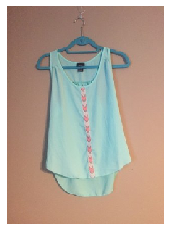

File:  ./data/01a0e_ktikQhVhaH6U97UDHnZPFVe9.jpeg
Raw prediction:  {'cc3': [0.00393979158, 0.0479443036, 0.0336780399, 0.00588661432, 0.908551216], 'tags': [0.291831762, 0.130647212, 0.0304449722]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




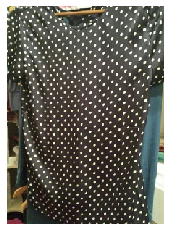

File:  ./data/0069e_resRbhTQb5RRnZdVoPhnF9WD.jpeg
Raw prediction:  {'tags': [0.979294837, 0.000602978515, 0.0115359928], 'cc3': [0.15684244, 0.208329275, 0.45169881, 0.139603436, 0.043526046]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




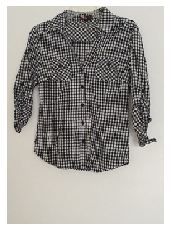

File:  ./data/00c2e_HQekkaVqqs8aA6LVsGxu9z2C.jpeg
Raw prediction:  {'cc3': [0.176007167, 0.0485417098, 0.061058294, 0.713382721, 0.0010101056], 'tags': [0.116988368, 0.00152654061, 0.474332601]}
cc3: ['shirts', 'blouses']
tags: []




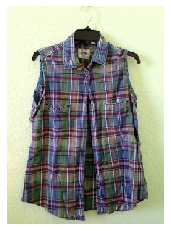

File:  ./data/002aa_HqWaDR4GsA2SCNjyxCxNFp8G.jpeg
Raw prediction:  {'tags': [0.000391388312, 0.0227875467, 0.924851477], 'cc3': [0.0421961881, 0.336028636, 0.280871123, 0.128986344, 0.211917803]}
cc3: ['casual_dresses', 'mini_dresses']
tags: ['checker']




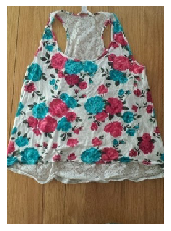

File:  ./data/02054_ZECoJehwvAdJL16nPRdTSCg9.jpeg
Raw prediction:  {'cc3': [0.0730540305, 0.0321882069, 0.738744736, 0.0739726573, 0.0820403695], 'tags': [0.00396847399, 0.998816, 0.000346829271]}
cc3: ['mini_dresses', 'tank_tops']
tags: ['floral']




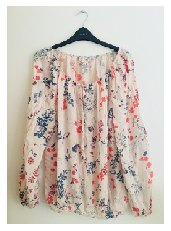

File:  ./data/04440_wvRdux79mncLLWBMEgXhygkW.jpeg
Raw prediction:  {'cc3': [0.44723776, 0.108993754, 0.205442652, 0.20574069, 0.0325851366], 'tags': [0.534626186, 0.701403, 0.000849375501]}
cc3: ['blouses', 'shirts']
tags: ['polka dot', 'floral']




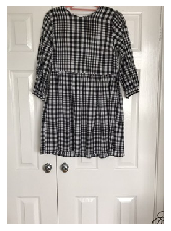

File:  ./data/03a9a_7FnRvUr2J1kaaRSrCUMychK3.jpeg
Raw prediction:  {'tags': [0.0333928168, 0.0108700935, 0.923600912], 'cc3': [0.0792972445, 0.671544194, 0.0292331614, 0.215624496, 0.00430084253]}
cc3: ['casual_dresses', 'shirts']
tags: ['checker']




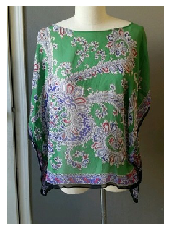

File:  ./data/0049a_JPUyWH7TWdHE87sxGEZDNAdH.jpeg
Raw prediction:  {'tags': [0.0197495129, 0.856884599, 0.000567196461], 'cc3': [0.58566159, 0.0521071702, 0.270438433, 0.00326379901, 0.088529028]}
cc3: ['blouses', 'mini_dresses']
tags: ['floral']




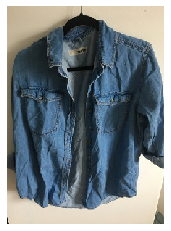

File:  ./data/0332f_14WqgZJJF7i8ReXh8WAUx2Q2.jpeg
Raw prediction:  {'tags': [0.00384455197, 0.284418792, 0.189631015], 'cc3': [0.0492968448, 0.0209000856, 0.0511394292, 0.853013217, 0.0256503858]}
cc3: ['shirts', 'mini_dresses']
tags: []




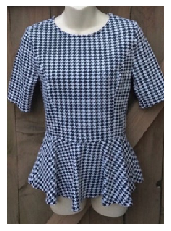

File:  ./data/02abe_P1ZpWHXp3CkrrZzdrnnkU4uS.jpeg
Raw prediction:  {'tags': [0.24131529, 0.00039659391, 0.227027655], 'cc3': [0.0318205878, 0.75017494, 0.160605609, 0.0540126227, 0.00338631473]}
cc3: ['casual_dresses', 'mini_dresses']
tags: []




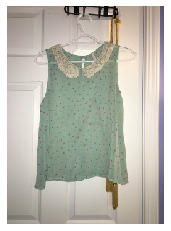

File:  ./data/04b58_zRM75iXqsbaZGJbMiTu2m23v.jpeg
Raw prediction:  {'tags': [0.190919936, 0.13769789, 0.0167398769], 'cc3': [0.0432714, 0.144805908, 0.0597531945, 0.0248221699, 0.727347374]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




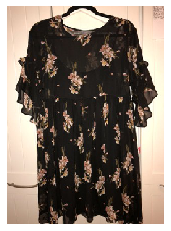

File:  ./data/025e3_k5tFffWF6JFT1FoCNN3CFXFR.jpeg
Raw prediction:  {'tags': [0.0051214085, 0.988998473, 0.00122141524], 'cc3': [0.43163541, 0.172598213, 0.208107561, 0.185826421, 0.00183239242]}
cc3: ['blouses', 'mini_dresses']
tags: ['floral']




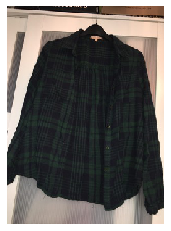

File:  ./data/0477d_LWbCxVJSu3kmVHo18SZHaS5W.jpeg
Raw prediction:  {'tags': [0.0410147309, 0.0665736943, 0.701296926], 'cc3': [0.105927162, 0.0218900777, 0.0462441035, 0.820013762, 0.0059248074]}
cc3: ['shirts', 'blouses']
tags: ['checker']




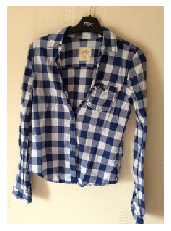

File:  ./data/02473_TQXWauKKoP7CUABQygX3nx9w.jpeg
Raw prediction:  {'tags': [1.2544152e-05, 0.00452693598, 0.957002699], 'cc3': [0.00444590161, 0.000990713248, 0.00109559356, 0.993406892, 6.08554255e-05]}
cc3: ['shirts', 'blouses']
tags: ['checker']




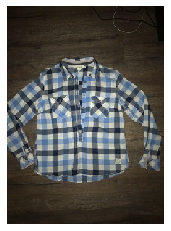

File:  ./data/04cbf_QvUPbGVPAeUm8yUWScPMDexD.jpeg
Raw prediction:  {'cc3': [0.0103350664, 0.00209018, 0.00375086, 0.981835, 0.00198880467], 'tags': [4.36920564e-05, 0.00455376366, 0.954078674]}
cc3: ['shirts', 'blouses']
tags: ['checker']




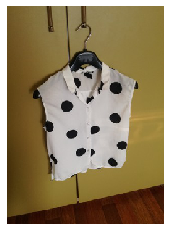

File:  ./data/02641_yvJuwvhrWKuj4NYeDbQLsbk5.jpeg
Raw prediction:  {'tags': [0.94857806, 0.141191557, 0.00533618499], 'cc3': [0.0748100355, 0.0235709772, 0.0908663049, 0.277674675, 0.533078]}
cc3: ['tank_tops', 'shirts']
tags: ['polka dot']




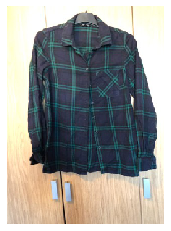

File:  ./data/03eb8_DSv8V4DMW1iY5gdSn41JcK5W.jpeg
Raw prediction:  {'cc3': [0.0107402056, 0.00381886167, 0.000793965068, 0.980965555, 0.0036814406], 'tags': [0.00143803062, 0.0799446, 0.750627]}
cc3: ['shirts', 'blouses']
tags: ['checker']




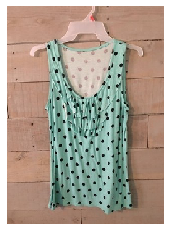

File:  ./data/01373_55JR3dXAn726mZvAssinLwu4.jpeg
Raw prediction:  {'tags': [0.993341744, 0.54018873, 1.75975902e-06], 'cc3': [0.00202398282, 0.00795133598, 0.0345249884, 4.9019287e-05, 0.955450714]}
cc3: ['tank_tops', 'mini_dresses']
tags: ['polka dot', 'floral']




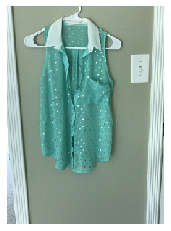

File:  ./data/00f83_1nLu7kQZnUvqyA3MzguVoYbV.jpeg
Raw prediction:  {'tags': [0.316633105, 0.459302306, 0.0123507502], 'cc3': [0.15498665, 0.497691423, 0.114189513, 0.022216294, 0.210916072]}
cc3: ['casual_dresses', 'tank_tops']
tags: []




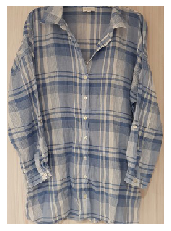

File:  ./data/03eba_qhLBHC5bZp9ngT183k5tfBLv.jpeg
Raw prediction:  {'tags': [8.62740126e-05, 0.000662710343, 0.922135353], 'cc3': [0.0172199216, 0.00856666267, 0.00199716398, 0.971628487, 0.000587695395]}
cc3: ['shirts', 'blouses']
tags: ['checker']




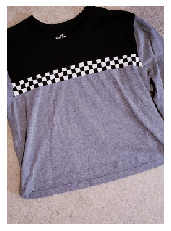

File:  ./data/03fc2_Hi7thDaCFDGz6foBBHKdcKbY.jpeg
Raw prediction:  {'tags': [0.0935354754, 0.179386362, 0.00247983728], 'cc3': [0.197588027, 0.0991593525, 0.171200797, 0.0500607677, 0.481991]}
cc3: ['tank_tops', 'blouses']
tags: []




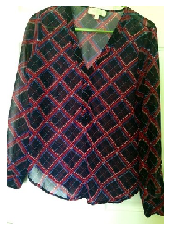

File:  ./data/006a2_SiahAnL18pWNVzb4cbB6RL8w.jpeg
Raw prediction:  {'cc3': [0.144766882, 0.00896820799, 0.00290497043, 0.836903632, 0.00645629317], 'tags': [0.000529073877, 0.00105625053, 0.978035569]}
cc3: ['shirts', 'blouses']
tags: ['checker']




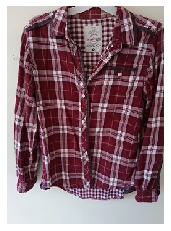

File:  ./data/02611_B5boEBY17LS9zx7Xc2vLPhHh.jpeg
Raw prediction:  {'tags': [0.00154989481, 0.00146314967, 0.394958317], 'cc3': [0.0639644042, 0.00561628817, 0.00105843914, 0.92682153, 0.00253928499]}
cc3: ['shirts', 'blouses']
tags: []




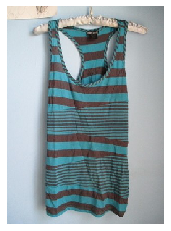

File:  ./data/00d95_W4dHv9LbkdaGKpjy8PZobKMD.jpeg
Raw prediction:  {'tags': [0.00309482962, 0.0616954565, 0.125855088], 'cc3': [0.0277032591, 0.240509599, 0.109961711, 0.00508632651, 0.616739094]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




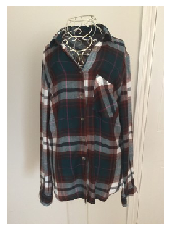

File:  ./data/04db7_FLzMNtVDq7D6aFBhXoQBkY7H.jpeg
Raw prediction:  {'tags': [0.00038128483, 0.0336191729, 0.216269419], 'cc3': [0.0114128953, 0.000739295, 0.000151818604, 0.98619312, 0.0015027856]}
cc3: ['shirts', 'blouses']
tags: []




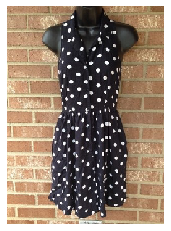

File:  ./data/01215_1oYxWozgf5wFo3ftN7pFEeAS.jpeg
Raw prediction:  {'tags': [0.984914124, 0.038752526, 0.00174487231], 'cc3': [0.00327684474, 0.351576775, 0.635394156, 0.00119086367, 0.00856143888]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




In [43]:
# ========================================
# Example of serving on a list of pictures
# ========================================

#for file in data_balanced['uuid'][2600:2610].tolist():
for file in test_pd['uuid'][0:40].tolist():
    

    #file = './data/00a5f_ozkvtHQfYePXmFMPyBjWao97.jpeg'
    #file = './data/02acd_vP63wx1pq9avpoLptz47kd7r.jpeg'
    #file = './data/0436c_3UNwTkvQBb5qS8A7ENmuVkiJ.jpeg'
    file = './data/{}'.format(file)
    
    img = tf.keras.preprocessing.image.load_img(file, target_size=[height,width])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    x = tf.keras.preprocessing.image.img_to_array(img) / 255. 
    x = x[tf.newaxis,...]

    data = json.dumps({"signature_name": "serving_default","instances": x.tolist()})
    headers = {"content-type": "application/json"}
    json_response = requests.post('http://localhost:9000/v1/models/my_model:predict',
                                  data=data, headers=headers)
    predictions = np.array(json.loads(json_response.text)["predictions"])[0]
    
    print('File: ', file)
    print('Raw prediction: ', predictions)

    # Getting 2 highest probability indices for cc3
    ind_cc3 = heapq.nlargest(2, range(len(predictions['cc3'])), predictions['cc3'].__getitem__) 
    print('cc3:', [columns_cc3[item] for item in ind_cc3])

    # Getting indices of tags for which probability > 0.5
    ind_tags = [i for i, x in enumerate(predictions['tags']) if x>=0.5]
    print('tags:', [columns_tags[item] for item in ind_tags])
    print()
    print()